In [28]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
import shap

In [29]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [30]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [31]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0815_variable.csv')
test = pd.read_csv('./data/test_0815_variable.csv')

In [32]:
train.columns

Index(['target', 'inconsistant', 'stage1_dist_cat', 'stage2_dist_cat',
       'stage3_dist_cat', 'cure_time_dam', 'cure_time_fill2',
       'press21_autoclave', 'thon_time', 'discharged_dist_stage1_dam',
       'discharged_dist_stage2_dam', 'discharged_dist_stage3_dam',
       'discharged_dist_stage1_fill1', 'discharged_dist_stage2_fill1',
       'discharged_dist_stage3_fill1', 'equip', 'fill2_time', 'autoclave_time',
       'qty', 'thick1', 'thick2', 'thick3', 'chamber_temp', 'model_suffix',
       'select_workorder', 'select_pallet', 'direction', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3'],
      dtype='object')

In [33]:
# List of categorical columns
cat_cols = ['select_pallet', 'stage1_dist_cat', 'stage2_dist_cat', 'stage3_dist_cat',
           'chamber_temp']

# Convert categorical columns to category type
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [34]:
# 학습시 inconsistant 전부 빼고 적용
train_sel = train[train['inconsistant'] == 0]

In [35]:
# 각 영역별 
stage1 = ['target', 'stage1_dist_cat',
       'cure_time_dam', 'cure_time_fill2', 'thon_time',
       'thick1', 'volume_ratio_stage1',
       'discharged_dist_stage1_dam', 'discharged_dist_stage1_fill1',
       'select_pallet', 'select_workorder', 'direction', 'equip'
]

stage2 = [
        'target', 
       'stage2_dist_cat', 
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 
       'thick2', 'volume_ratio_stage2',
       'discharged_dist_stage2_dam', 'discharged_dist_stage2_fill1',
       'select_pallet', 'select_workorder', 'direction', 'equip'
]

stage3 = [
        'target', 'stage3_dist_cat',
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 
       'fill2_time', 'thick3', 'volume_ratio_stage3',
       'discharged_dist_stage3_dam', 'discharged_dist_stage3_fill1',
       'select_pallet', 'select_workorder', 'direction', 'equip'
]

autoclave = [
        'target',
       'press21_autoclave',
        'autoclave_time', 'select_pallet', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3', 
       'chamber_temp', 'select_workorder'
            ]

df_stage1 = train_sel[stage1]
df_stage2 = train_sel[stage2]
df_stage3 = train_sel[stage3]
df_autoclave = train_sel[autoclave]

# Stage1

In [41]:
X_stage1 = df_stage1.drop(columns=['target'])
y_stage1 = df_stage1['target']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage1, y_stage1, test_size=0.2, random_state=42, stratify = y_stage1)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",#"multi:softprob",#,#binary:logistic",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "random_state": 42,
        "early_stopping_rounds": 50,
        'enable_categorical': True
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    
    # CatBoost 모델 학습
    model = XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 03:48:58,895] A new study created in memory with name: no-name-6d0a42a0-6650-4581-b581-d7f8841d976b
[I 2024-08-16 03:49:16,043] Trial 0 finished with value: 0.494357940681985 and parameters: {'booster': 'dart', 'lambda': 2.5509822629265266e-07, 'alpha': 7.524492175092989e-06, 'subsample': 0.4010108205668152, 'colsample_bytree': 0.6673988898853049, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.1795140458649757, 'gamma': 1.5158277495032607e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.024986424906148e-06, 'skip_drop': 5.1334575519642787e-05}. Best is trial 0 with value: 0.494357940681985.
[I 2024-08-16 03:49:16,460] Trial 1 finished with value: 0.48565065224307985 and parameters: {'booster': 'gbtree', 'lambda': 4.2638693832016906e-08, 'alpha': 0.00024815219060559643, 'subsample': 0.9639198960308746, 'colsample_bytree': 0.47653264381512495, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.019693552218482357, 'gamma': 0.

[I 2024-08-16 03:50:49,463] Trial 18 finished with value: 0.48565065224307985 and parameters: {'booster': 'dart', 'lambda': 0.00015653200803873696, 'alpha': 0.002797911703230364, 'subsample': 0.8479585441524538, 'colsample_bytree': 0.8884644009412392, 'max_depth': 9, 'min_child_weight': 5, 'eta': 1.0712742649603841e-08, 'gamma': 9.258985688325078e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.9558368735323416, 'skip_drop': 0.7647983173142193}. Best is trial 11 with value: 0.513515843581235.
[I 2024-08-16 03:50:49,983] Trial 19 finished with value: 0.4965438298296414 and parameters: {'booster': 'gbtree', 'lambda': 0.035505864623898854, 'alpha': 0.06353384079538654, 'subsample': 0.6706426628629532, 'colsample_bytree': 0.70255174044055, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.035431768140337605, 'gamma': 0.004262597114311843, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.513515843581235.
[I 2024-08-16 03:50:50,44

[I 2024-08-16 03:52:32,326] Trial 37 finished with value: 0.48565065224307985 and parameters: {'booster': 'dart', 'lambda': 0.00035181890005268993, 'alpha': 2.2395291348640138e-05, 'subsample': 0.9523363757872243, 'colsample_bytree': 0.6047609631295416, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.021547719678857765, 'gamma': 0.00015741038186794072, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.5785086396609542e-08, 'skip_drop': 1.252020211185418e-06}. Best is trial 21 with value: 0.5136995512521056.
[I 2024-08-16 03:52:32,723] Trial 38 finished with value: 0.48565065224307985 and parameters: {'booster': 'gbtree', 'lambda': 1.106531665864207e-06, 'alpha': 0.10354211654407185, 'subsample': 0.7941033669347115, 'colsample_bytree': 0.9501479132313722, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.10548032900424785, 'gamma': 3.909230211815795e-06, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.5136995512521056.
[I 2024-08-16

Best trial:
  Value: 0.5136995512521056
  Params: 
    booster: gbtree
    lambda: 1.1662139779931864e-08
    alpha: 0.729417234229047
    subsample: 0.8296569880274791
    colsample_bytree: 0.8896007588531565
    max_depth: 9
    min_child_weight: 2
    eta: 0.5179973929248625
    gamma: 2.5789543236026542e-05
    grow_policy: lossguide


In [42]:
study.best_trial.params

{'booster': 'gbtree',
 'lambda': 1.1662139779931864e-08,
 'alpha': 0.729417234229047,
 'subsample': 0.8296569880274791,
 'colsample_bytree': 0.8896007588531565,
 'max_depth': 9,
 'min_child_weight': 2,
 'eta': 0.5179973929248625,
 'gamma': 2.5789543236026542e-05,
 'grow_policy': 'lossguide'}

In [52]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = study.best_trial.params
stage1_best_model = XGBClassifier(random_state = 42, enable_categorical= True, eval_metric = f1_scorer, **stage1_best_params)
stage1_best_model.fit(X_train, y_train)

XGBClassifier(alpha=0.729417234229047, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8896007588531565, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eta=0.5179973929248625,
              eval_metric=make_scorer(f1_score, pos_label=1, average=binary),
              feature_types=None, gamma=2.5789543236026542e-05,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, lambda=1.1662139779931864e-08,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

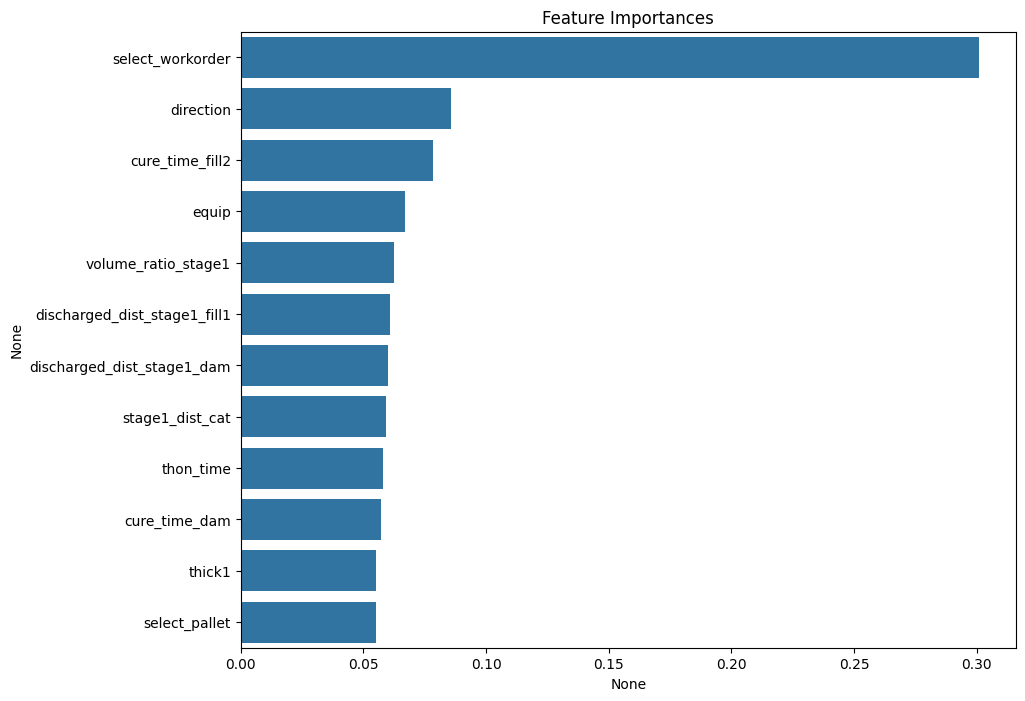

In [53]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [54]:
pred = stage1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  14  437]
 [  11 7621]]

정확도: 0.9446
정밀도: 0.5600
재현율: 0.0310
F1: 0.0588


# Stage2

In [13]:
X_stage2 = df_stage2.drop(columns=['target'])
y_stage2 = df_stage2['target']

cat_features_indices_stage2 = ['select_pallet', 'stage2_dist_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage2, y_stage2, test_size=0.2, random_state=42, stratify = y_stage2)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage2)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage2)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 17:38:20,385] A new study created in memory with name: no-name-2212cc1f-b11e-4431-b2bf-c39be8fed4c8
[I 2024-08-15 17:38:30,158] Trial 0 finished with value: 0.5615367225504463 and parameters: {'iterations': 797, 'depth': 10, 'learning_rate': 0.0014772790002696794, 'l2_leaf_reg': 4.411020043503421, 'border_count': 155, 'random_strength': 7.527503401130422, 'bagging_temperature': 0.7073046776191494, 'od_type': 'Iter', 'od_wait': 24, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5615367225504463.
[I 2024-08-15 17:38:31,597] Trial 1 finished with value: 0.5623358691826624 and parameters: {'iterations': 164, 'depth': 8, 'learning_rate': 0.015089477462613783, 'l2_leaf_reg': 6.909512355186277, 'border_count': 195, 'random_strength': 5.063356211083563, 'bagging_temperature': 0.7061072659737685, 'od_type': 'Iter', 'od_wait': 10, 'boosting_type': 'Ordered', 'scale_pos_weight': 9}. Best is trial 1 with value: 0.5623358691826624.
[I 2024-08-15 17:38

[I 2024-08-15 17:39:10,063] Trial 19 finished with value: 0.5640156362371738 and parameters: {'iterations': 614, 'depth': 7, 'learning_rate': 0.10435030428808141, 'l2_leaf_reg': 0.31911297915364045, 'border_count': 78, 'random_strength': 1.3852130163535503, 'bagging_temperature': 0.16229320543317438, 'od_type': 'Iter', 'od_wait': 11, 'boosting_type': 'Ordered', 'scale_pos_weight': 8}. Best is trial 2 with value: 0.57555496202787.
[I 2024-08-15 17:39:11,386] Trial 20 finished with value: 0.5623277991608435 and parameters: {'iterations': 763, 'depth': 6, 'learning_rate': 0.4997361238812049, 'l2_leaf_reg': 4.68239577521249, 'border_count': 169, 'random_strength': 6.170640758865453, 'bagging_temperature': 0.5718432323673355, 'od_type': 'IncToDec', 'od_wait': 38, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 2 with value: 0.57555496202787.
[I 2024-08-15 17:39:12,529] Trial 21 finished with value: 0.5657476613765178 and parameters: {'iterations': 454, 'depth': 6, 'learnin

[I 2024-08-15 17:39:47,696] Trial 38 finished with value: 0.5621373854947253 and parameters: {'iterations': 497, 'depth': 9, 'learning_rate': 0.1047543400047053, 'l2_leaf_reg': 2.014183244197373, 'border_count': 105, 'random_strength': 4.759584658317651, 'bagging_temperature': 0.6607110606075411, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Ordered', 'scale_pos_weight': 8}. Best is trial 29 with value: 0.5765682354068474.
[I 2024-08-15 17:39:50,985] Trial 39 finished with value: 0.5634650291931805 and parameters: {'iterations': 587, 'depth': 10, 'learning_rate': 0.22705295669381162, 'l2_leaf_reg': 4.036289135997361, 'border_count': 66, 'random_strength': 9.416368896114076, 'bagging_temperature': 0.5457088243409239, 'od_type': 'IncToDec', 'od_wait': 35, 'boosting_type': 'Ordered', 'scale_pos_weight': 6}. Best is trial 29 with value: 0.5765682354068474.
[I 2024-08-15 17:39:52,178] Trial 40 finished with value: 0.5626025218082956 and parameters: {'iterations': 193, 'depth': 9, 

Best trial:
  Value: 0.5765682354068474
  Params: 
    iterations: 110
    depth: 10
    learning_rate: 0.3500051938223222
    l2_leaf_reg: 1.004637956664944
    border_count: 150
    random_strength: 5.840194028713485
    bagging_temperature: 0.840954920942609
    od_type: IncToDec
    od_wait: 24
    boosting_type: Ordered
    scale_pos_weight: 6


In [14]:
study.best_trial.params

{'iterations': 110,
 'depth': 10,
 'learning_rate': 0.3500051938223222,
 'l2_leaf_reg': 1.004637956664944,
 'border_count': 150,
 'random_strength': 5.840194028713485,
 'bagging_temperature': 0.840954920942609,
 'od_type': 'IncToDec',
 'od_wait': 24,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 6}

In [15]:
# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = study.best_trial.params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage2)

0:	learn: 0.6048085	total: 27.5ms	remaining: 3s
1:	learn: 0.5687892	total: 34.7ms	remaining: 1.87s
2:	learn: 0.5431529	total: 61ms	remaining: 2.17s
3:	learn: 0.5286664	total: 87.9ms	remaining: 2.33s
4:	learn: 0.5255477	total: 91.8ms	remaining: 1.93s
5:	learn: 0.5193316	total: 97.3ms	remaining: 1.69s
6:	learn: 0.5186801	total: 100ms	remaining: 1.48s
7:	learn: 0.5159834	total: 108ms	remaining: 1.38s
8:	learn: 0.5132592	total: 117ms	remaining: 1.32s
9:	learn: 0.5117449	total: 144ms	remaining: 1.44s
10:	learn: 0.5112845	total: 150ms	remaining: 1.35s
11:	learn: 0.5112602	total: 156ms	remaining: 1.27s
12:	learn: 0.5081125	total: 184ms	remaining: 1.37s
13:	learn: 0.5080226	total: 189ms	remaining: 1.3s
14:	learn: 0.5079712	total: 195ms	remaining: 1.23s
15:	learn: 0.5071161	total: 204ms	remaining: 1.2s
16:	learn: 0.5070335	total: 209ms	remaining: 1.14s
17:	learn: 0.5058843	total: 236ms	remaining: 1.21s
18:	learn: 0.5058773	total: 240ms	remaining: 1.15s
19:	learn: 0.5052900	total: 250ms	remainin

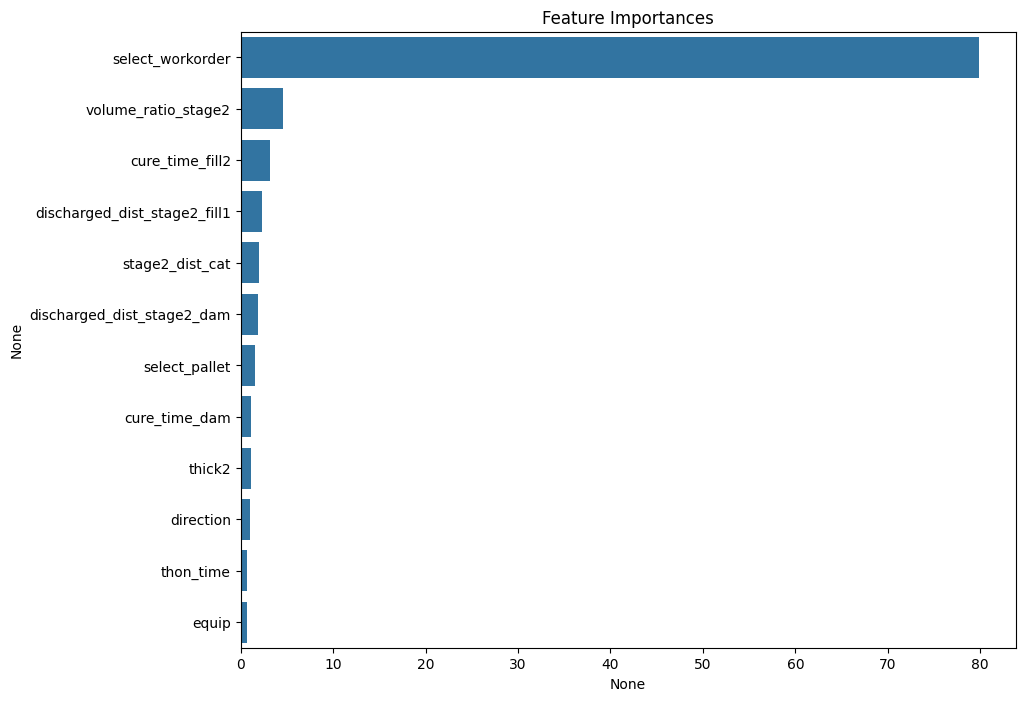

In [16]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [17]:
pred = stage2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  94  357]
 [ 413 7219]]

정확도: 0.9047
정밀도: 0.1854
재현율: 0.2084
F1: 0.1962


# Stage3

In [18]:
X_stage3 = df_stage3.drop(columns=['target'])
y_stage3 = df_stage3['target']

cat_features_indices_stage3 = ['select_pallet', 'stage3_dist_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage3, y_stage3, test_size=0.2, random_state=42, stratify = y_stage3)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage3)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage3)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 17:40:08,721] A new study created in memory with name: no-name-b5ece16e-5985-4571-956c-c3a8343a8912
[I 2024-08-15 17:40:19,465] Trial 0 finished with value: 0.5623358691826624 and parameters: {'iterations': 620, 'depth': 7, 'learning_rate': 0.001380352780712879, 'l2_leaf_reg': 8.522074834529851, 'border_count': 150, 'random_strength': 7.563037019683866, 'bagging_temperature': 0.633335141713916, 'od_type': 'IncToDec', 'od_wait': 19, 'boosting_type': 'Ordered', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5623358691826624.
[I 2024-08-15 17:40:21,768] Trial 1 finished with value: 0.5642585271480843 and parameters: {'iterations': 413, 'depth': 9, 'learning_rate': 0.062493760574765515, 'l2_leaf_reg': 6.650987698195057, 'border_count': 193, 'random_strength': 5.571540174506746, 'bagging_temperature': 0.3059192388669355, 'od_type': 'IncToDec', 'od_wait': 27, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 1 with value: 0.5642585271480843.
[I 2024-08-1

[I 2024-08-15 17:40:59,071] Trial 19 finished with value: 0.5617982891876021 and parameters: {'iterations': 640, 'depth': 8, 'learning_rate': 0.013865739169083813, 'l2_leaf_reg': 3.697639942556977, 'border_count': 60, 'random_strength': 8.902427228348852, 'bagging_temperature': 0.503455218530798, 'od_type': 'IncToDec', 'od_wait': 15, 'boosting_type': 'Plain', 'scale_pos_weight': 8}. Best is trial 8 with value: 0.5733773041340301.
[I 2024-08-15 17:41:03,512] Trial 20 finished with value: 0.5620595881961522 and parameters: {'iterations': 970, 'depth': 8, 'learning_rate': 0.0028667554805885437, 'l2_leaf_reg': 5.497796956356533, 'border_count': 219, 'random_strength': 8.19620233369754, 'bagging_temperature': 0.869445875768604, 'od_type': 'IncToDec', 'od_wait': 32, 'boosting_type': 'Plain', 'scale_pos_weight': 8}. Best is trial 8 with value: 0.5733773041340301.
[I 2024-08-15 17:41:03,788] Trial 21 finished with value: 0.5704806799851684 and parameters: {'iterations': 483, 'depth': 5, 'learn

[I 2024-08-15 17:41:17,269] Trial 38 finished with value: 0.5690007597011761 and parameters: {'iterations': 359, 'depth': 8, 'learning_rate': 0.0025491389801517105, 'l2_leaf_reg': 6.368154503696818, 'border_count': 150, 'random_strength': 6.0519531408097755, 'bagging_temperature': 0.4042336290200822, 'od_type': 'IncToDec', 'od_wait': 49, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 33 with value: 0.5749404690193722.
[I 2024-08-15 17:41:18,444] Trial 39 finished with value: 0.5660685545168292 and parameters: {'iterations': 298, 'depth': 6, 'learning_rate': 0.004914726704082602, 'l2_leaf_reg': 4.041225462076, 'border_count': 201, 'random_strength': 5.24136027735561, 'bagging_temperature': 0.1291421014310521, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 33 with value: 0.5749404690193722.
[I 2024-08-15 17:41:19,503] Trial 40 finished with value: 0.5620335985714364 and parameters: {'iterations': 237, 'depth': 7, 'le

Best trial:
  Value: 0.5772262026947642
  Params: 
    iterations: 572
    depth: 7
    learning_rate: 0.00372401107729057
    l2_leaf_reg: 3.3440550980116206
    border_count: 162
    random_strength: 8.143551115225513
    bagging_temperature: 0.7956731824672139
    od_type: IncToDec
    od_wait: 16
    boosting_type: Plain
    scale_pos_weight: 7


In [19]:
study.best_trial.params

{'iterations': 572,
 'depth': 7,
 'learning_rate': 0.00372401107729057,
 'l2_leaf_reg': 3.3440550980116206,
 'border_count': 162,
 'random_strength': 8.143551115225513,
 'bagging_temperature': 0.7956731824672139,
 'od_type': 'IncToDec',
 'od_wait': 16,
 'boosting_type': 'Plain',
 'scale_pos_weight': 7}

In [20]:
# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = study.best_trial.params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage3)

0:	learn: 0.6920630	total: 4.17ms	remaining: 2.38s
1:	learn: 0.6909631	total: 8.68ms	remaining: 2.47s
2:	learn: 0.6898884	total: 11.6ms	remaining: 2.2s
3:	learn: 0.6881614	total: 15.8ms	remaining: 2.24s
4:	learn: 0.6870645	total: 19.9ms	remaining: 2.25s
5:	learn: 0.6860299	total: 22.9ms	remaining: 2.16s
6:	learn: 0.6850064	total: 25.5ms	remaining: 2.06s
7:	learn: 0.6839186	total: 29.6ms	remaining: 2.08s
8:	learn: 0.6828605	total: 33.5ms	remaining: 2.1s
9:	learn: 0.6818300	total: 37.6ms	remaining: 2.11s
10:	learn: 0.6804430	total: 41.8ms	remaining: 2.13s
11:	learn: 0.6794219	total: 45.8ms	remaining: 2.14s
12:	learn: 0.6783834	total: 50ms	remaining: 2.15s
13:	learn: 0.6774329	total: 52.7ms	remaining: 2.1s
14:	learn: 0.6759123	total: 56.8ms	remaining: 2.11s
15:	learn: 0.6749336	total: 60.3ms	remaining: 2.1s
16:	learn: 0.6739692	total: 64.6ms	remaining: 2.11s
17:	learn: 0.6730016	total: 68.7ms	remaining: 2.11s
18:	learn: 0.6720651	total: 71.1ms	remaining: 2.07s
19:	learn: 0.6711061	total: 

200:	learn: 0.5694250	total: 770ms	remaining: 1.42s
201:	learn: 0.5691906	total: 774ms	remaining: 1.42s
202:	learn: 0.5689639	total: 778ms	remaining: 1.41s
203:	learn: 0.5687459	total: 782ms	remaining: 1.41s
204:	learn: 0.5685447	total: 785ms	remaining: 1.4s
205:	learn: 0.5682896	total: 789ms	remaining: 1.4s
206:	learn: 0.5680910	total: 792ms	remaining: 1.4s
207:	learn: 0.5679792	total: 795ms	remaining: 1.39s
208:	learn: 0.5677579	total: 799ms	remaining: 1.39s
209:	learn: 0.5675477	total: 803ms	remaining: 1.38s
210:	learn: 0.5674314	total: 807ms	remaining: 1.38s
211:	learn: 0.5673163	total: 810ms	remaining: 1.38s
212:	learn: 0.5670971	total: 814ms	remaining: 1.37s
213:	learn: 0.5667281	total: 818ms	remaining: 1.37s
214:	learn: 0.5665037	total: 822ms	remaining: 1.36s
215:	learn: 0.5663039	total: 826ms	remaining: 1.36s
216:	learn: 0.5661749	total: 830ms	remaining: 1.36s
217:	learn: 0.5659716	total: 834ms	remaining: 1.35s
218:	learn: 0.5657685	total: 838ms	remaining: 1.35s
219:	learn: 0.5

367:	learn: 0.5459382	total: 1.41s	remaining: 782ms
368:	learn: 0.5457799	total: 1.41s	remaining: 778ms
369:	learn: 0.5456281	total: 1.42s	remaining: 775ms
370:	learn: 0.5455424	total: 1.42s	remaining: 771ms
371:	learn: 0.5454723	total: 1.43s	remaining: 767ms
372:	learn: 0.5454339	total: 1.43s	remaining: 764ms
373:	learn: 0.5452889	total: 1.44s	remaining: 760ms
374:	learn: 0.5452283	total: 1.44s	remaining: 755ms
375:	learn: 0.5450809	total: 1.44s	remaining: 751ms
376:	learn: 0.5449768	total: 1.45s	remaining: 747ms
377:	learn: 0.5449246	total: 1.45s	remaining: 744ms
378:	learn: 0.5448528	total: 1.45s	remaining: 740ms
379:	learn: 0.5447800	total: 1.46s	remaining: 737ms
380:	learn: 0.5446404	total: 1.46s	remaining: 733ms
381:	learn: 0.5445837	total: 1.46s	remaining: 728ms
382:	learn: 0.5445499	total: 1.47s	remaining: 725ms
383:	learn: 0.5445206	total: 1.47s	remaining: 721ms
384:	learn: 0.5444177	total: 1.48s	remaining: 717ms
385:	learn: 0.5442779	total: 1.48s	remaining: 713ms
386:	learn: 

564:	learn: 0.5357220	total: 2.18s	remaining: 27ms
565:	learn: 0.5357087	total: 2.18s	remaining: 23.1ms
566:	learn: 0.5356920	total: 2.19s	remaining: 19.3ms
567:	learn: 0.5356382	total: 2.19s	remaining: 15.4ms
568:	learn: 0.5356254	total: 2.19s	remaining: 11.6ms
569:	learn: 0.5355745	total: 2.2s	remaining: 7.71ms
570:	learn: 0.5355414	total: 2.2s	remaining: 3.85ms
571:	learn: 0.5355347	total: 2.2s	remaining: 0us


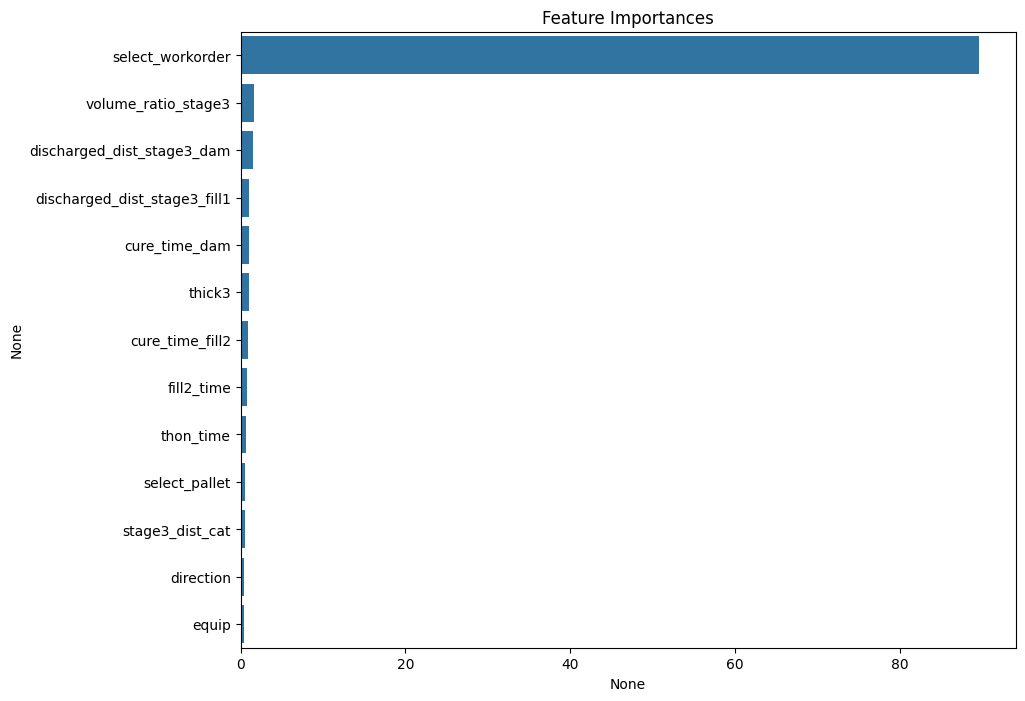

In [21]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage3_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [22]:
pred = stage3_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 150  301]
 [ 736 6896]]

정확도: 0.8717
정밀도: 0.1693
재현율: 0.3326
F1: 0.2244


# AutoClave

In [23]:
X_AutoClave = df_autoclave.drop(columns=['target'])
y_AutoClave = df_autoclave['target']

cat_features_indices_autoclave = ['select_pallet', 'chamber_temp']

X_train, X_valid, y_train, y_valid = train_test_split(X_AutoClave, y_AutoClave, test_size=0.2, random_state=42, stratify = y_AutoClave)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_autoclave)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_autoclave)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 17:41:50,249] A new study created in memory with name: no-name-0dad96aa-1941-4bb8-a71d-21d443d2882f
[I 2024-08-15 17:42:00,858] Trial 0 finished with value: 0.5618864180801898 and parameters: {'iterations': 733, 'depth': 5, 'learning_rate': 0.0019172357959748357, 'l2_leaf_reg': 5.201762606497864, 'border_count': 136, 'random_strength': 6.540769678355229, 'bagging_temperature': 0.6628403808937707, 'od_type': 'Iter', 'od_wait': 30, 'boosting_type': 'Ordered', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.5618864180801898.
[I 2024-08-15 17:42:01,659] Trial 1 finished with value: 0.5534641822730465 and parameters: {'iterations': 368, 'depth': 8, 'learning_rate': 0.34860708582326255, 'l2_leaf_reg': 7.311292477708928, 'border_count': 69, 'random_strength': 8.580827582982796, 'bagging_temperature': 0.8280628051723139, 'od_type': 'Iter', 'od_wait': 12, 'boosting_type': 'Plain', 'scale_pos_weight': 6}. Best is trial 0 with value: 0.5618864180801898.
[I 2024-08-15 17:42:03,

[I 2024-08-15 17:42:54,297] Trial 19 finished with value: 0.5672537703943047 and parameters: {'iterations': 649, 'depth': 6, 'learning_rate': 0.0052605843807820634, 'l2_leaf_reg': 1.0496761781237371, 'border_count': 226, 'random_strength': 2.194926677365517, 'bagging_temperature': 0.5386956991720371, 'od_type': 'IncToDec', 'od_wait': 41, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 12 with value: 0.5684449123404628.
[I 2024-08-15 17:42:54,800] Trial 20 finished with value: 0.5591672006871822 and parameters: {'iterations': 125, 'depth': 7, 'learning_rate': 0.08299884007775903, 'l2_leaf_reg': 4.719933836210792, 'border_count': 252, 'random_strength': 1.115661803352736, 'bagging_temperature': 0.28952287648768954, 'od_type': 'IncToDec', 'od_wait': 50, 'boosting_type': 'Plain', 'scale_pos_weight': 8}. Best is trial 12 with value: 0.5684449123404628.
[I 2024-08-15 17:43:00,812] Trial 21 finished with value: 0.5666389171617786 and parameters: {'iterations': 651, 'depth': 6,

[I 2024-08-15 17:43:58,811] Trial 38 finished with value: 0.5621336396330843 and parameters: {'iterations': 942, 'depth': 6, 'learning_rate': 0.21640671863097224, 'l2_leaf_reg': 9.768092913488228, 'border_count': 221, 'random_strength': 3.5714954016878693, 'bagging_temperature': 0.5329690465299308, 'od_type': 'IncToDec', 'od_wait': 23, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 12 with value: 0.5684449123404628.
[I 2024-08-15 17:44:00,189] Trial 39 finished with value: 0.5666509891794614 and parameters: {'iterations': 618, 'depth': 9, 'learning_rate': 0.11362014083081166, 'l2_leaf_reg': 2.9469707031830286, 'border_count': 123, 'random_strength': 2.725810331879375, 'bagging_temperature': 0.4585378390452026, 'od_type': 'Iter', 'od_wait': 44, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 12 with value: 0.5684449123404628.
[I 2024-08-15 17:44:06,592] Trial 40 finished with value: 0.5687988284381893 and parameters: {'iterations': 364, 'depth': 8, 'lear

Best trial:
  Value: 0.5702210272316942
  Params: 
    iterations: 561
    depth: 8
    learning_rate: 0.008609359975796371
    l2_leaf_reg: 3.997950510762003
    border_count: 235
    random_strength: 8.116552364135142
    bagging_temperature: 0.7117510011603234
    od_type: IncToDec
    od_wait: 45
    boosting_type: Ordered
    scale_pos_weight: 7


In [24]:
study.best_trial.params

{'iterations': 561,
 'depth': 8,
 'learning_rate': 0.008609359975796371,
 'l2_leaf_reg': 3.997950510762003,
 'border_count': 235,
 'random_strength': 8.116552364135142,
 'bagging_temperature': 0.7117510011603234,
 'od_type': 'IncToDec',
 'od_wait': 45,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 7}

In [25]:
# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(random_state = 42, **AutoClave_best_params)
AutoClave_best_model.fit(X_train, y_train, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6905329	total: 27.9ms	remaining: 15.6s
1:	learn: 0.6889959	total: 38.8ms	remaining: 10.8s
2:	learn: 0.6865478	total: 55.1ms	remaining: 10.3s
3:	learn: 0.6828151	total: 82.2ms	remaining: 11.4s
4:	learn: 0.6790096	total: 109ms	remaining: 12.1s
5:	learn: 0.6757965	total: 128ms	remaining: 11.8s
6:	learn: 0.6735758	total: 145ms	remaining: 11.5s
7:	learn: 0.6712843	total: 164ms	remaining: 11.4s
8:	learn: 0.6675341	total: 179ms	remaining: 11s
9:	learn: 0.6662325	total: 190ms	remaining: 10.5s
10:	learn: 0.6641256	total: 209ms	remaining: 10.4s
11:	learn: 0.6620920	total: 230ms	remaining: 10.5s
12:	learn: 0.6601368	total: 247ms	remaining: 10.4s
13:	learn: 0.6581631	total: 262ms	remaining: 10.3s
14:	learn: 0.6562976	total: 279ms	remaining: 10.1s
15:	learn: 0.6551495	total: 288ms	remaining: 9.82s
16:	learn: 0.6533001	total: 304ms	remaining: 9.72s
17:	learn: 0.6502009	total: 321ms	remaining: 9.67s
18:	learn: 0.6469968	total: 335ms	remaining: 9.56s
19:	learn: 0.6459409	total: 349ms	remai

162:	learn: 0.5514814	total: 2.88s	remaining: 7.04s
163:	learn: 0.5510000	total: 2.9s	remaining: 7.03s
164:	learn: 0.5509434	total: 2.92s	remaining: 7.01s
165:	learn: 0.5506966	total: 2.94s	remaining: 7s
166:	learn: 0.5506421	total: 2.95s	remaining: 6.97s
167:	learn: 0.5503538	total: 2.98s	remaining: 6.97s
168:	learn: 0.5503017	total: 2.99s	remaining: 6.94s
169:	learn: 0.5498491	total: 3.02s	remaining: 6.95s
170:	learn: 0.5496301	total: 3.04s	remaining: 6.93s
171:	learn: 0.5495811	total: 3.05s	remaining: 6.89s
172:	learn: 0.5494059	total: 3.06s	remaining: 6.87s
173:	learn: 0.5493136	total: 3.09s	remaining: 6.88s
174:	learn: 0.5491311	total: 3.11s	remaining: 6.87s
175:	learn: 0.5490855	total: 3.12s	remaining: 6.83s
176:	learn: 0.5490406	total: 3.14s	remaining: 6.8s
177:	learn: 0.5489867	total: 3.15s	remaining: 6.79s
178:	learn: 0.5487685	total: 3.18s	remaining: 6.79s
179:	learn: 0.5483965	total: 3.21s	remaining: 6.79s
180:	learn: 0.5482388	total: 3.23s	remaining: 6.77s
181:	learn: 0.548

326:	learn: 0.5371104	total: 5.8s	remaining: 4.15s
327:	learn: 0.5370860	total: 5.82s	remaining: 4.13s
328:	learn: 0.5370486	total: 5.84s	remaining: 4.12s
329:	learn: 0.5370392	total: 5.86s	remaining: 4.1s
330:	learn: 0.5370330	total: 5.87s	remaining: 4.08s
331:	learn: 0.5370292	total: 5.89s	remaining: 4.06s
332:	learn: 0.5370194	total: 5.9s	remaining: 4.04s
333:	learn: 0.5370171	total: 5.91s	remaining: 4.02s
334:	learn: 0.5370081	total: 5.93s	remaining: 4s
335:	learn: 0.5369513	total: 5.95s	remaining: 3.98s
336:	learn: 0.5369437	total: 5.96s	remaining: 3.96s
337:	learn: 0.5369395	total: 5.97s	remaining: 3.94s
338:	learn: 0.5369102	total: 5.99s	remaining: 3.92s
339:	learn: 0.5368830	total: 6s	remaining: 3.9s
340:	learn: 0.5368647	total: 6.03s	remaining: 3.89s
341:	learn: 0.5368631	total: 6.04s	remaining: 3.86s
342:	learn: 0.5368092	total: 6.05s	remaining: 3.85s
343:	learn: 0.5368032	total: 6.07s	remaining: 3.83s
344:	learn: 0.5367699	total: 6.09s	remaining: 3.82s
345:	learn: 0.5367580	

494:	learn: 0.5342625	total: 8.71s	remaining: 1.16s
495:	learn: 0.5342615	total: 8.73s	remaining: 1.14s
496:	learn: 0.5342614	total: 8.74s	remaining: 1.13s
497:	learn: 0.5342444	total: 8.76s	remaining: 1.11s
498:	learn: 0.5342401	total: 8.77s	remaining: 1.09s
499:	learn: 0.5342391	total: 8.79s	remaining: 1.07s
500:	learn: 0.5342390	total: 8.79s	remaining: 1.05s
501:	learn: 0.5342381	total: 8.81s	remaining: 1.03s
502:	learn: 0.5342293	total: 8.83s	remaining: 1.02s
503:	learn: 0.5341969	total: 8.86s	remaining: 1s
504:	learn: 0.5341722	total: 8.89s	remaining: 986ms
505:	learn: 0.5341580	total: 8.9s	remaining: 968ms
506:	learn: 0.5341540	total: 8.92s	remaining: 950ms
507:	learn: 0.5341539	total: 8.93s	remaining: 932ms
508:	learn: 0.5341537	total: 8.94s	remaining: 914ms
509:	learn: 0.5341536	total: 8.95s	remaining: 895ms
510:	learn: 0.5341388	total: 8.97s	remaining: 878ms
511:	learn: 0.5341388	total: 8.98s	remaining: 859ms
512:	learn: 0.5341154	total: 9.01s	remaining: 843ms
513:	learn: 0.53

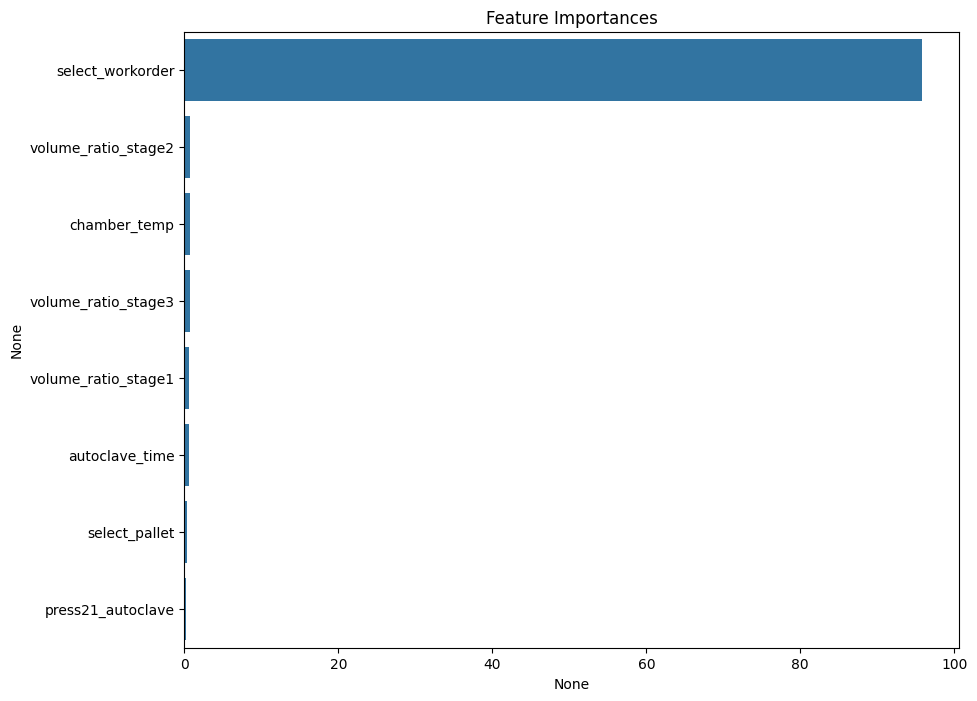

In [26]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(AutoClave_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [27]:
pred = AutoClave_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 128  323]
 [ 674 6958]]

정확도: 0.8767
정밀도: 0.1596
재현율: 0.2838
F1: 0.2043


# 민감성

In [28]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(random_state = 42, **dam_best_params)
dam_best_model.fit(X_stage1, y_stage1, cat_features=cat_features_indices_stage1)

# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(random_state = 42, **fill1_best_params)
fill1_best_model.fit(X_stage2, y_stage2, cat_features=cat_features_indices_stage2)

# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(random_state = 42, **fill2_best_params)
fill2_best_model.fit(X_stage3, y_stage3, cat_features=cat_features_indices_stage3)

# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(random_state = 42, **AutoClave_best_params)
AutoClave_best_model.fit(X_AutoClave, y_AutoClave, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6889607	total: 24.2ms	remaining: 13.6s
1:	learn: 0.6864377	total: 50.9ms	remaining: 14.2s
2:	learn: 0.6824377	total: 71.2ms	remaining: 13.2s
3:	learn: 0.6808244	total: 87.5ms	remaining: 12.2s
4:	learn: 0.6785996	total: 103ms	remaining: 11.4s
5:	learn: 0.6763282	total: 119ms	remaining: 11s
6:	learn: 0.6728351	total: 147ms	remaining: 11.7s
7:	learn: 0.6693235	total: 175ms	remaining: 12.1s
8:	learn: 0.6671754	total: 203ms	remaining: 12.4s
9:	learn: 0.6658922	total: 213ms	remaining: 11.7s
10:	learn: 0.6631971	total: 242ms	remaining: 12.1s
11:	learn: 0.6611599	total: 262ms	remaining: 12s
12:	learn: 0.6579834	total: 289ms	remaining: 12.2s
13:	learn: 0.6561168	total: 307ms	remaining: 12s
14:	learn: 0.6533455	total: 321ms	remaining: 11.7s
15:	learn: 0.6522233	total: 331ms	remaining: 11.3s
16:	learn: 0.6504423	total: 352ms	remaining: 11.3s
17:	learn: 0.6484735	total: 383ms	remaining: 11.5s
18:	learn: 0.6467432	total: 414ms	remaining: 11.8s
19:	learn: 0.6449408	total: 442ms	remaining

166:	learn: 0.5533385	total: 3.18s	remaining: 7.5s
167:	learn: 0.5531417	total: 3.19s	remaining: 7.47s
168:	learn: 0.5529474	total: 3.22s	remaining: 7.47s
169:	learn: 0.5525726	total: 3.24s	remaining: 7.46s
170:	learn: 0.5523580	total: 3.27s	remaining: 7.46s
171:	learn: 0.5522378	total: 3.3s	remaining: 7.46s
172:	learn: 0.5517612	total: 3.32s	remaining: 7.45s
173:	learn: 0.5517144	total: 3.33s	remaining: 7.41s
174:	learn: 0.5515439	total: 3.36s	remaining: 7.41s
175:	learn: 0.5510798	total: 3.38s	remaining: 7.4s
176:	learn: 0.5509296	total: 3.4s	remaining: 7.37s
177:	learn: 0.5508513	total: 3.42s	remaining: 7.37s
178:	learn: 0.5507043	total: 3.44s	remaining: 7.34s
179:	learn: 0.5505603	total: 3.45s	remaining: 7.31s
180:	learn: 0.5501313	total: 3.48s	remaining: 7.31s
181:	learn: 0.5500926	total: 3.49s	remaining: 7.27s
182:	learn: 0.5498755	total: 3.52s	remaining: 7.27s
183:	learn: 0.5494482	total: 3.54s	remaining: 7.25s
184:	learn: 0.5493168	total: 3.55s	remaining: 7.21s
185:	learn: 0.54

328:	learn: 0.5382781	total: 6.3s	remaining: 4.44s
329:	learn: 0.5382510	total: 6.31s	remaining: 4.42s
330:	learn: 0.5382488	total: 6.32s	remaining: 4.39s
331:	learn: 0.5382467	total: 6.33s	remaining: 4.37s
332:	learn: 0.5382420	total: 6.35s	remaining: 4.35s
333:	learn: 0.5382355	total: 6.37s	remaining: 4.33s
334:	learn: 0.5381678	total: 6.39s	remaining: 4.31s
335:	learn: 0.5380897	total: 6.42s	remaining: 4.3s
336:	learn: 0.5379397	total: 6.45s	remaining: 4.28s
337:	learn: 0.5378711	total: 6.46s	remaining: 4.26s
338:	learn: 0.5378674	total: 6.48s	remaining: 4.24s
339:	learn: 0.5378659	total: 6.49s	remaining: 4.22s
340:	learn: 0.5377730	total: 6.51s	remaining: 4.2s
341:	learn: 0.5377450	total: 6.53s	remaining: 4.18s
342:	learn: 0.5377436	total: 6.54s	remaining: 4.16s
343:	learn: 0.5377377	total: 6.56s	remaining: 4.13s
344:	learn: 0.5377364	total: 6.57s	remaining: 4.11s
345:	learn: 0.5376773	total: 6.59s	remaining: 4.09s
346:	learn: 0.5376760	total: 6.6s	remaining: 4.07s
347:	learn: 0.53

488:	learn: 0.5351772	total: 9.14s	remaining: 1.34s
489:	learn: 0.5351765	total: 9.15s	remaining: 1.33s
490:	learn: 0.5351754	total: 9.17s	remaining: 1.31s
491:	learn: 0.5351727	total: 9.18s	remaining: 1.29s
492:	learn: 0.5351500	total: 9.21s	remaining: 1.27s
493:	learn: 0.5351496	total: 9.22s	remaining: 1.25s
494:	learn: 0.5351433	total: 9.24s	remaining: 1.23s
495:	learn: 0.5351429	total: 9.26s	remaining: 1.21s
496:	learn: 0.5351428	total: 9.27s	remaining: 1.19s
497:	learn: 0.5351349	total: 9.29s	remaining: 1.18s
498:	learn: 0.5350919	total: 9.32s	remaining: 1.16s
499:	learn: 0.5350708	total: 9.34s	remaining: 1.14s
500:	learn: 0.5350701	total: 9.36s	remaining: 1.12s
501:	learn: 0.5350345	total: 9.38s	remaining: 1.1s
502:	learn: 0.5350233	total: 9.4s	remaining: 1.08s
503:	learn: 0.5349961	total: 9.43s	remaining: 1.06s
504:	learn: 0.5349751	total: 9.45s	remaining: 1.05s
505:	learn: 0.5349750	total: 9.46s	remaining: 1.03s
506:	learn: 0.5349740	total: 9.47s	remaining: 1.01s
507:	learn: 0.

89:	learn: 0.5767996	total: 1.71s	remaining: 8.93s
90:	learn: 0.5762521	total: 1.73s	remaining: 8.92s
91:	learn: 0.5760103	total: 1.74s	remaining: 8.86s
92:	learn: 0.5755024	total: 1.76s	remaining: 8.84s
93:	learn: 0.5752692	total: 1.77s	remaining: 8.78s
94:	learn: 0.5750401	total: 1.78s	remaining: 8.73s
95:	learn: 0.5747637	total: 1.79s	remaining: 8.68s
96:	learn: 0.5744961	total: 1.8s	remaining: 8.63s
97:	learn: 0.5734354	total: 1.83s	remaining: 8.66s
98:	learn: 0.5724152	total: 1.86s	remaining: 8.69s
99:	learn: 0.5722104	total: 1.87s	remaining: 8.63s
100:	learn: 0.5720026	total: 1.89s	remaining: 8.59s
101:	learn: 0.5715542	total: 1.9s	remaining: 8.54s
102:	learn: 0.5712695	total: 1.92s	remaining: 8.54s
103:	learn: 0.5710729	total: 1.94s	remaining: 8.5s
104:	learn: 0.5705943	total: 1.96s	remaining: 8.49s
105:	learn: 0.5700491	total: 1.99s	remaining: 8.53s
106:	learn: 0.5698002	total: 2.02s	remaining: 8.55s
107:	learn: 0.5695728	total: 2.03s	remaining: 8.52s
108:	learn: 0.5691525	tota

254:	learn: 0.5418076	total: 4.88s	remaining: 5.86s
255:	learn: 0.5417989	total: 4.89s	remaining: 5.83s
256:	learn: 0.5417894	total: 4.91s	remaining: 5.81s
257:	learn: 0.5417810	total: 4.92s	remaining: 5.78s
258:	learn: 0.5417719	total: 4.94s	remaining: 5.75s
259:	learn: 0.5417537	total: 4.95s	remaining: 5.74s
260:	learn: 0.5417457	total: 4.96s	remaining: 5.71s
261:	learn: 0.5417379	total: 4.97s	remaining: 5.68s
262:	learn: 0.5415874	total: 5s	remaining: 5.66s
263:	learn: 0.5415797	total: 5.01s	remaining: 5.64s
264:	learn: 0.5415719	total: 5.03s	remaining: 5.62s
265:	learn: 0.5415214	total: 5.04s	remaining: 5.59s
266:	learn: 0.5415089	total: 5.05s	remaining: 5.57s
267:	learn: 0.5415017	total: 5.07s	remaining: 5.54s
268:	learn: 0.5414851	total: 5.08s	remaining: 5.52s
269:	learn: 0.5414761	total: 5.1s	remaining: 5.49s
270:	learn: 0.5414677	total: 5.11s	remaining: 5.47s
271:	learn: 0.5414612	total: 5.13s	remaining: 5.45s
272:	learn: 0.5414323	total: 5.15s	remaining: 5.44s
273:	learn: 0.54

421:	learn: 0.5367343	total: 7.83s	remaining: 2.58s
422:	learn: 0.5366787	total: 7.86s	remaining: 2.56s
423:	learn: 0.5366129	total: 7.88s	remaining: 2.55s
424:	learn: 0.5366070	total: 7.91s	remaining: 2.53s
425:	learn: 0.5365643	total: 7.93s	remaining: 2.51s
426:	learn: 0.5365641	total: 7.94s	remaining: 2.49s
427:	learn: 0.5365637	total: 7.95s	remaining: 2.47s
428:	learn: 0.5365610	total: 7.96s	remaining: 2.45s
429:	learn: 0.5365568	total: 7.98s	remaining: 2.43s
430:	learn: 0.5365501	total: 8.01s	remaining: 2.42s
431:	learn: 0.5364861	total: 8.04s	remaining: 2.4s
432:	learn: 0.5364815	total: 8.06s	remaining: 2.38s
433:	learn: 0.5364813	total: 8.07s	remaining: 2.36s
434:	learn: 0.5364213	total: 8.09s	remaining: 2.34s
435:	learn: 0.5364184	total: 8.1s	remaining: 2.32s
436:	learn: 0.5364158	total: 8.12s	remaining: 2.3s
437:	learn: 0.5364152	total: 8.13s	remaining: 2.28s
438:	learn: 0.5364145	total: 8.14s	remaining: 2.26s
439:	learn: 0.5363727	total: 8.16s	remaining: 2.24s
440:	learn: 0.5

24:	learn: 0.6366302	total: 525ms	remaining: 11.3s
25:	learn: 0.6356537	total: 537ms	remaining: 11s
26:	learn: 0.6341749	total: 552ms	remaining: 10.9s
27:	learn: 0.6326763	total: 575ms	remaining: 10.9s
28:	learn: 0.6312709	total: 587ms	remaining: 10.8s
29:	learn: 0.6298916	total: 599ms	remaining: 10.6s
30:	learn: 0.6283645	total: 621ms	remaining: 10.6s
31:	learn: 0.6258590	total: 644ms	remaining: 10.6s
32:	learn: 0.6234451	total: 668ms	remaining: 10.7s
33:	learn: 0.6225233	total: 688ms	remaining: 10.7s
34:	learn: 0.6212294	total: 711ms	remaining: 10.7s
35:	learn: 0.6198947	total: 735ms	remaining: 10.7s
36:	learn: 0.6176101	total: 756ms	remaining: 10.7s
37:	learn: 0.6154141	total: 779ms	remaining: 10.7s
38:	learn: 0.6142687	total: 792ms	remaining: 10.6s
39:	learn: 0.6130356	total: 815ms	remaining: 10.6s
40:	learn: 0.6119133	total: 832ms	remaining: 10.5s
41:	learn: 0.6107435	total: 855ms	remaining: 10.6s
42:	learn: 0.6085637	total: 869ms	remaining: 10.5s
43:	learn: 0.6074365	total: 892ms

193:	learn: 0.5397446	total: 3.92s	remaining: 7.42s
194:	learn: 0.5396479	total: 3.94s	remaining: 7.4s
195:	learn: 0.5396146	total: 3.96s	remaining: 7.37s
196:	learn: 0.5394334	total: 3.98s	remaining: 7.35s
197:	learn: 0.5393221	total: 4s	remaining: 7.34s
198:	learn: 0.5391540	total: 4.03s	remaining: 7.33s
199:	learn: 0.5389758	total: 4.05s	remaining: 7.31s
200:	learn: 0.5388876	total: 4.07s	remaining: 7.3s
201:	learn: 0.5387738	total: 4.1s	remaining: 7.28s
202:	learn: 0.5386498	total: 4.11s	remaining: 7.25s
203:	learn: 0.5384752	total: 4.13s	remaining: 7.24s
204:	learn: 0.5384023	total: 4.16s	remaining: 7.22s
205:	learn: 0.5382942	total: 4.18s	remaining: 7.2s
206:	learn: 0.5382705	total: 4.19s	remaining: 7.17s
207:	learn: 0.5381646	total: 4.21s	remaining: 7.14s
208:	learn: 0.5381238	total: 4.23s	remaining: 7.13s
209:	learn: 0.5380134	total: 4.25s	remaining: 7.11s
210:	learn: 0.5379368	total: 4.28s	remaining: 7.09s
211:	learn: 0.5378273	total: 4.3s	remaining: 7.08s
212:	learn: 0.537707

358:	learn: 0.5308826	total: 7.33s	remaining: 4.13s
359:	learn: 0.5308674	total: 7.36s	remaining: 4.11s
360:	learn: 0.5308515	total: 7.38s	remaining: 4.09s
361:	learn: 0.5308310	total: 7.4s	remaining: 4.07s
362:	learn: 0.5308049	total: 7.42s	remaining: 4.05s
363:	learn: 0.5307786	total: 7.45s	remaining: 4.03s
364:	learn: 0.5307593	total: 7.47s	remaining: 4.01s
365:	learn: 0.5307471	total: 7.48s	remaining: 3.99s
366:	learn: 0.5307456	total: 7.5s	remaining: 3.96s
367:	learn: 0.5307211	total: 7.51s	remaining: 3.94s
368:	learn: 0.5306984	total: 7.53s	remaining: 3.92s
369:	learn: 0.5306876	total: 7.54s	remaining: 3.9s
370:	learn: 0.5306588	total: 7.57s	remaining: 3.88s
371:	learn: 0.5306479	total: 7.58s	remaining: 3.85s
372:	learn: 0.5306373	total: 7.6s	remaining: 3.83s
373:	learn: 0.5306012	total: 7.62s	remaining: 3.81s
374:	learn: 0.5305857	total: 7.65s	remaining: 3.79s
375:	learn: 0.5305708	total: 7.66s	remaining: 3.77s
376:	learn: 0.5305523	total: 7.68s	remaining: 3.75s
377:	learn: 0.53

519:	learn: 0.5278912	total: 10.8s	remaining: 848ms
520:	learn: 0.5278879	total: 10.8s	remaining: 827ms
521:	learn: 0.5278769	total: 10.8s	remaining: 806ms
522:	learn: 0.5278716	total: 10.8s	remaining: 785ms
523:	learn: 0.5278378	total: 10.8s	remaining: 765ms
524:	learn: 0.5278206	total: 10.9s	remaining: 744ms
525:	learn: 0.5278158	total: 10.9s	remaining: 723ms
526:	learn: 0.5278037	total: 10.9s	remaining: 703ms
527:	learn: 0.5277965	total: 10.9s	remaining: 682ms
528:	learn: 0.5277876	total: 10.9s	remaining: 661ms
529:	learn: 0.5277852	total: 10.9s	remaining: 640ms
530:	learn: 0.5277817	total: 11s	remaining: 619ms
531:	learn: 0.5277794	total: 11s	remaining: 599ms
532:	learn: 0.5277603	total: 11s	remaining: 578ms
533:	learn: 0.5277579	total: 11s	remaining: 558ms
534:	learn: 0.5277286	total: 11.1s	remaining: 537ms
535:	learn: 0.5277110	total: 11.1s	remaining: 517ms
536:	learn: 0.5277054	total: 11.1s	remaining: 496ms
537:	learn: 0.5276916	total: 11.1s	remaining: 475ms
538:	learn: 0.527682

124:	learn: 0.5617677	total: 2.3s	remaining: 8.03s
125:	learn: 0.5614503	total: 2.32s	remaining: 8.02s
126:	learn: 0.5607722	total: 2.34s	remaining: 8s
127:	learn: 0.5604662	total: 2.36s	remaining: 7.98s
128:	learn: 0.5598435	total: 2.38s	remaining: 7.95s
129:	learn: 0.5597257	total: 2.39s	remaining: 7.92s
130:	learn: 0.5595810	total: 2.4s	remaining: 7.89s
131:	learn: 0.5593047	total: 2.42s	remaining: 7.86s
132:	learn: 0.5591946	total: 2.43s	remaining: 7.81s
133:	learn: 0.5589039	total: 2.45s	remaining: 7.8s
134:	learn: 0.5587674	total: 2.46s	remaining: 7.76s
135:	learn: 0.5586631	total: 2.47s	remaining: 7.71s
136:	learn: 0.5585606	total: 2.48s	remaining: 7.67s
137:	learn: 0.5584566	total: 2.49s	remaining: 7.63s
138:	learn: 0.5583352	total: 2.5s	remaining: 7.61s
139:	learn: 0.5576199	total: 2.54s	remaining: 7.63s
140:	learn: 0.5575257	total: 2.55s	remaining: 7.58s
141:	learn: 0.5569991	total: 2.57s	remaining: 7.58s
142:	learn: 0.5565432	total: 2.59s	remaining: 7.57s
143:	learn: 0.55609

286:	learn: 0.5386047	total: 5.45s	remaining: 5.2s
287:	learn: 0.5385886	total: 5.47s	remaining: 5.18s
288:	learn: 0.5384706	total: 5.49s	remaining: 5.17s
289:	learn: 0.5383852	total: 5.51s	remaining: 5.15s
290:	learn: 0.5383416	total: 5.53s	remaining: 5.13s
291:	learn: 0.5383313	total: 5.55s	remaining: 5.11s
292:	learn: 0.5382805	total: 5.57s	remaining: 5.09s
293:	learn: 0.5382477	total: 5.58s	remaining: 5.07s
294:	learn: 0.5382437	total: 5.59s	remaining: 5.04s
295:	learn: 0.5382398	total: 5.6s	remaining: 5.01s
296:	learn: 0.5382249	total: 5.62s	remaining: 5s
297:	learn: 0.5382211	total: 5.63s	remaining: 4.97s
298:	learn: 0.5381658	total: 5.67s	remaining: 4.96s
299:	learn: 0.5381622	total: 5.67s	remaining: 4.94s
300:	learn: 0.5380942	total: 5.7s	remaining: 4.93s
301:	learn: 0.5380195	total: 5.72s	remaining: 4.91s
302:	learn: 0.5380092	total: 5.73s	remaining: 4.88s
303:	learn: 0.5379990	total: 5.74s	remaining: 4.86s
304:	learn: 0.5379113	total: 5.77s	remaining: 4.84s
305:	learn: 0.5379

447:	learn: 0.5348483	total: 8.59s	remaining: 2.17s
448:	learn: 0.5348268	total: 8.62s	remaining: 2.15s
449:	learn: 0.5348194	total: 8.63s	remaining: 2.13s
450:	learn: 0.5347992	total: 8.65s	remaining: 2.11s
451:	learn: 0.5347978	total: 8.67s	remaining: 2.09s
452:	learn: 0.5347972	total: 8.68s	remaining: 2.07s
453:	learn: 0.5347928	total: 8.69s	remaining: 2.05s
454:	learn: 0.5347291	total: 8.72s	remaining: 2.03s
455:	learn: 0.5347178	total: 8.73s	remaining: 2.01s
456:	learn: 0.5347176	total: 8.74s	remaining: 1.99s
457:	learn: 0.5347174	total: 8.76s	remaining: 1.97s
458:	learn: 0.5347114	total: 8.77s	remaining: 1.95s
459:	learn: 0.5347078	total: 8.79s	remaining: 1.93s
460:	learn: 0.5347076	total: 8.8s	remaining: 1.91s
461:	learn: 0.5347002	total: 8.83s	remaining: 1.89s
462:	learn: 0.5346754	total: 8.86s	remaining: 1.88s
463:	learn: 0.5346749	total: 8.87s	remaining: 1.85s
464:	learn: 0.5346710	total: 8.9s	remaining: 1.84s
465:	learn: 0.5346664	total: 8.91s	remaining: 1.82s
466:	learn: 0.

In [29]:
test_stage1_x = test[X_stage1.columns]
test_stage2_x = test[X_stage2.columns]
test_stage3_x = test[X_stage3.columns]
test_AutoClave_x = test[X_AutoClave.columns]

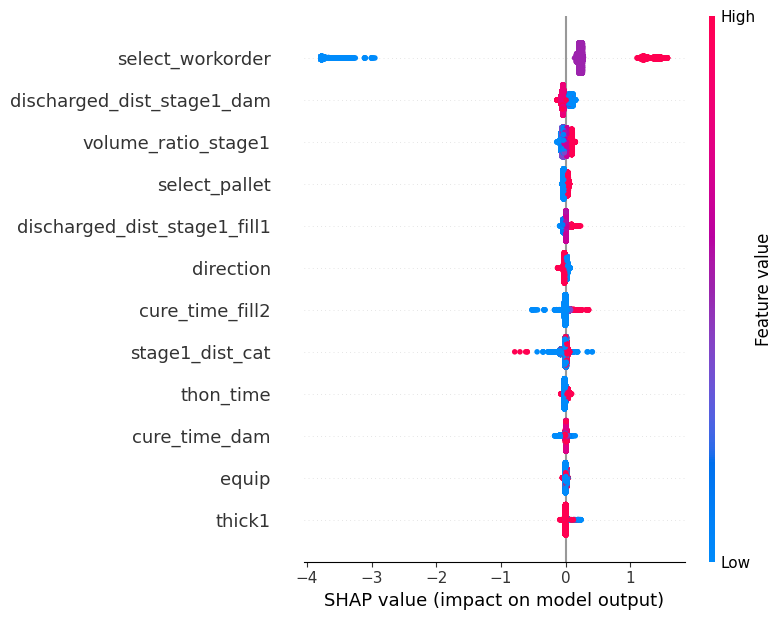

In [30]:
explainer = shap.Explainer(dam_best_model)
shap_values = explainer(test_stage1_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage1_x)

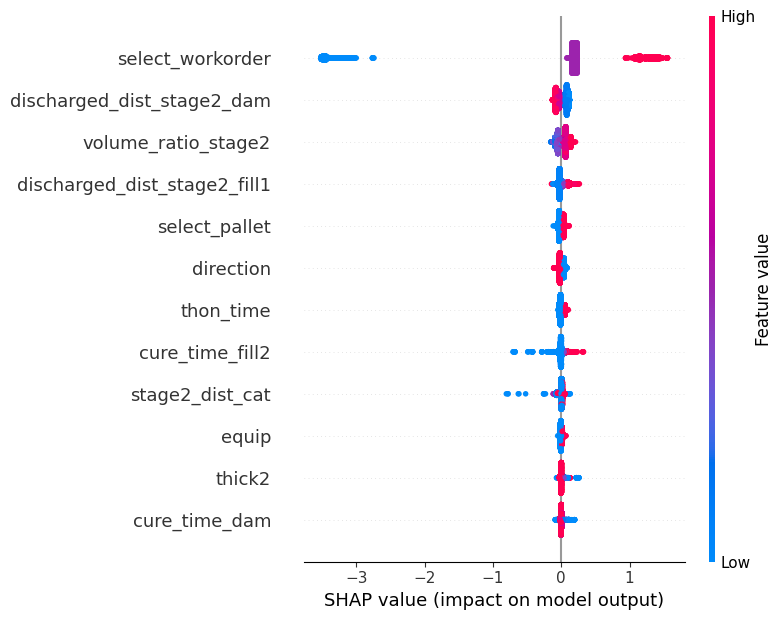

In [31]:
explainer = shap.Explainer(fill1_best_model)
shap_values = explainer(test_stage2_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage2_x)

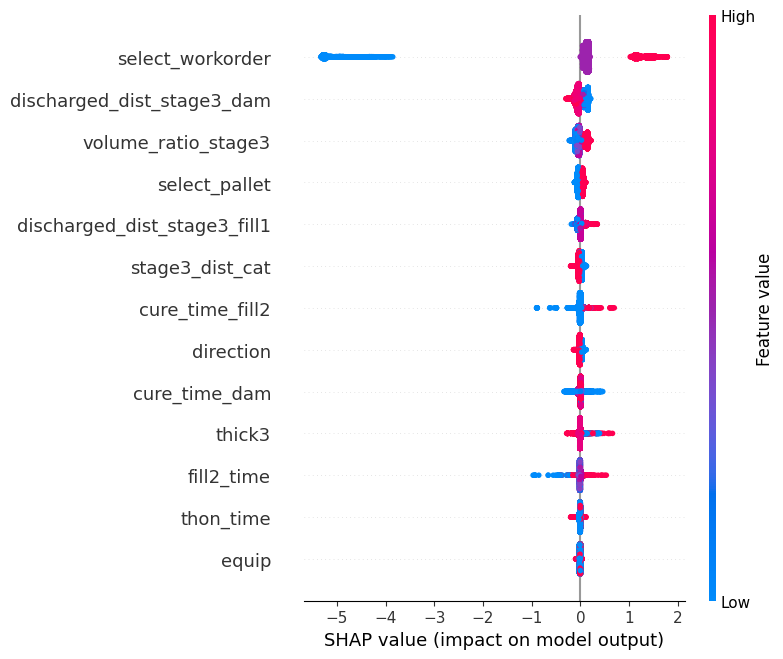

In [32]:
explainer = shap.Explainer(fill2_best_model)
shap_values = explainer(test_stage3_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage3_x)

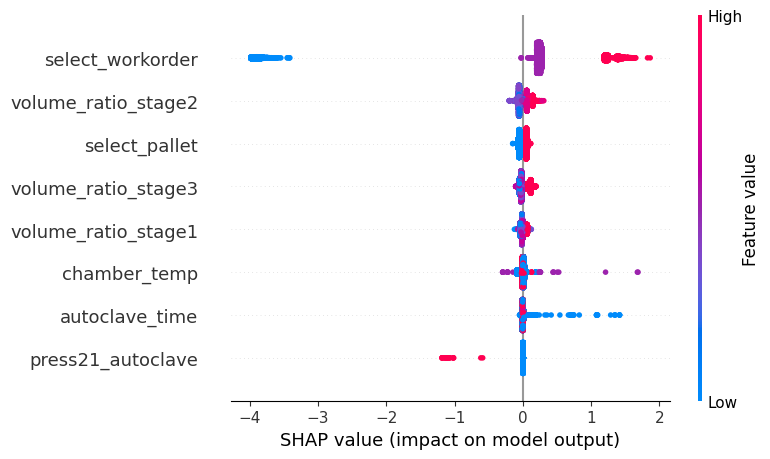

In [33]:
explainer = shap.Explainer(AutoClave_best_model)
shap_values = explainer(test_AutoClave_x)
shap.initjs()

shap.summary_plot(shap_values, test_AutoClave_x)

In [34]:
dam_test_pred = dam_best_model.predict(test_stage1_x)
dam_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
fill1_test_pred = fill1_best_model.predict(test_stage2_x)
fill1_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
fill2_test_pred = fill2_best_model.predict(test_stage3_x)
fill2_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
AutoClave_test_pred = AutoClave_best_model.predict(test_AutoClave_x)
AutoClave_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
result = np.logical_or(dam_test_pred, fill1_test_pred)
result = np.logical_or(result, fill2_test_pred)
result = np.logical_or(result, AutoClave_test_pred)

In [39]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [40]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([ 2374, 14987]))

In [41]:
test['target'] = y_pred

In [42]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,2361,14972
1,13,15


In [43]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [44]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,2361,14972
1,28,0


In [45]:
test.columns

Index(['Set ID', 'inconsistant', 'stage1_dist_cat', 'stage2_dist_cat',
       'stage3_dist_cat', 'cure_time_dam', 'cure_time_fill2',
       'press21_autoclave', 'thon_time', 'discharged_dist_stage1_dam',
       'discharged_dist_stage2_dam', 'discharged_dist_stage3_dam',
       'discharged_dist_stage1_fill1', 'discharged_dist_stage2_fill1',
       'discharged_dist_stage3_fill1', 'equip', 'fill2_time', 'autoclave_time',
       'qty', 'thick1', 'thick2', 'thick3', 'chamber_temp', 'model_suffix',
       'select_workorder', 'select_pallet', 'direction', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3', 'target'],
      dtype='object')

<Axes: >

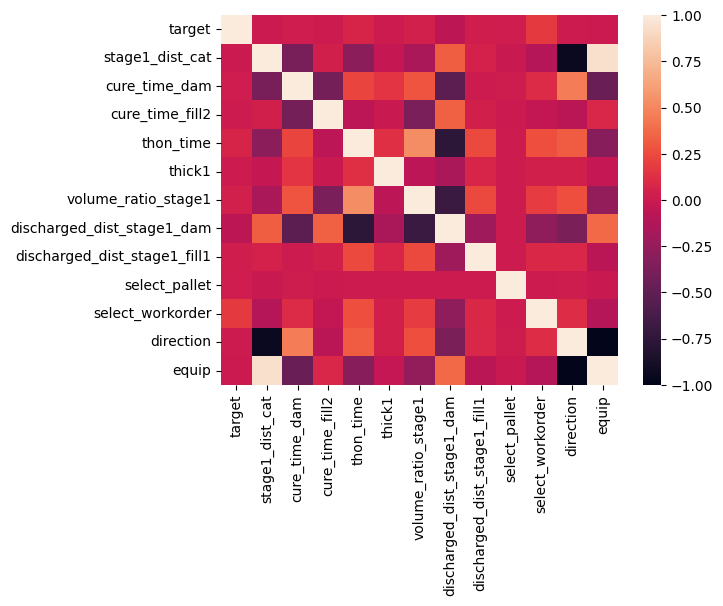

In [46]:
sns.heatmap(df_stage1.corr(), vmin=-1, vmax=1)

<Axes: >

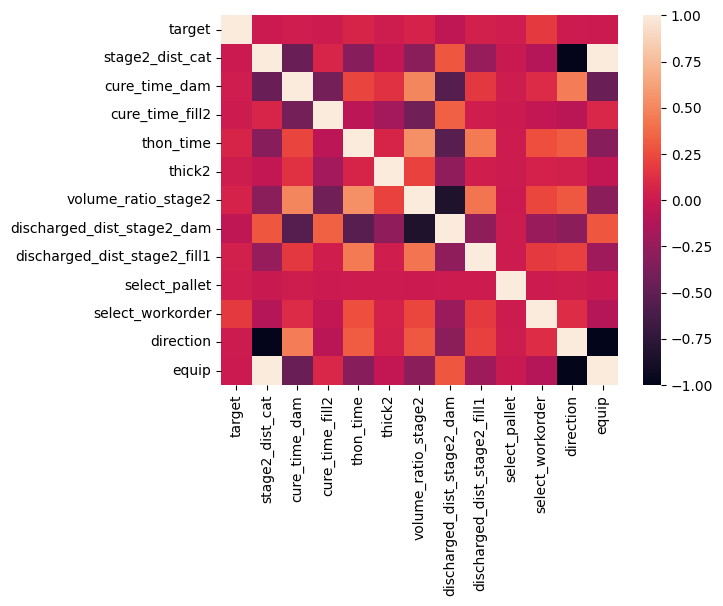

In [47]:
sns.heatmap(df_stage2.corr(), vmin=-1, vmax=1)

<Axes: >

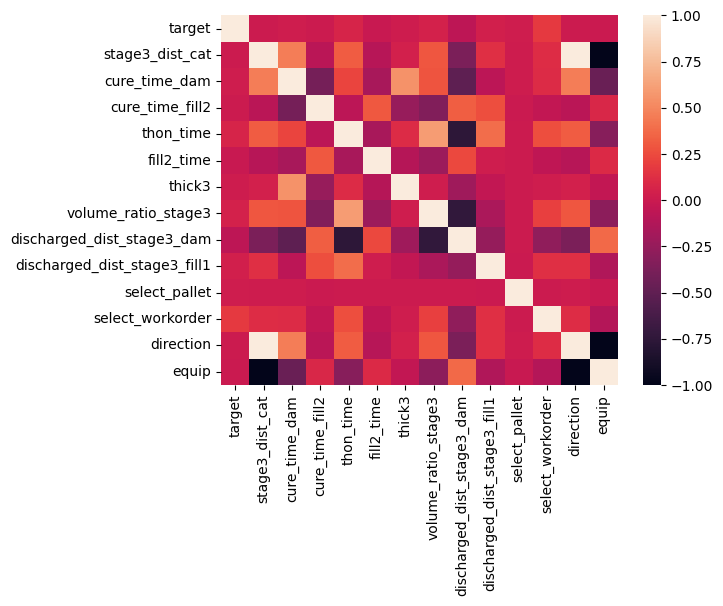

In [48]:
sns.heatmap(df_stage3.corr(), vmin=-1, vmax=1)

<Axes: >

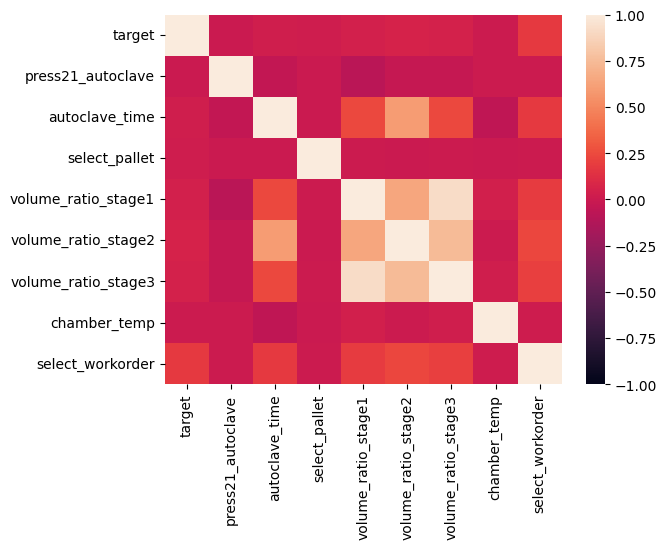

In [49]:
sns.heatmap(df_autoclave.corr(), vmin=-1, vmax=1)

<Axes: >

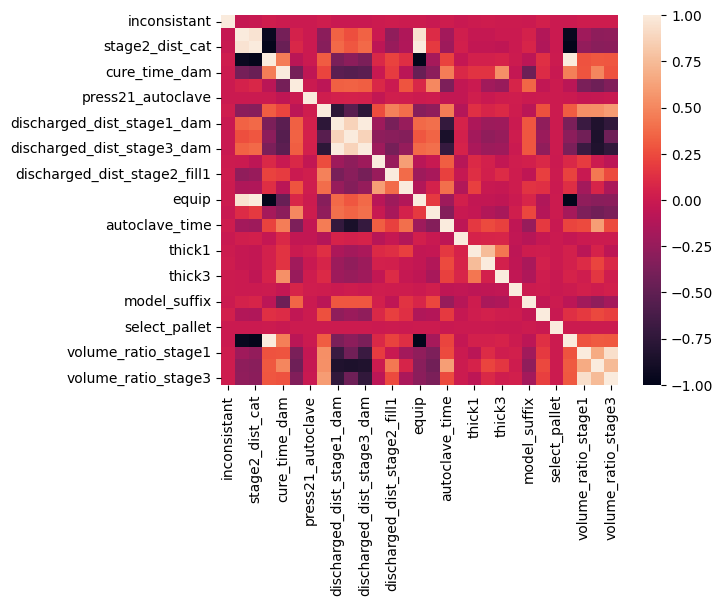

In [50]:
sns.heatmap(test.iloc[:, 1:-1].corr(), vmin=-1, vmax=1)

In [51]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)